# Adding observational effects in your model power spectrum

You should first check [why is it important to have the correct survey dimension](https://meer21cm.readthedocs.io/en/latest/cookbook/survey_dimension.html). Then, hopefully now you are already familiar with creating a survey volume and corresponding k-modes:

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from meer21cm import util
from meer21cm.plot import plot_map
from meer21cm import PowerSpectrum

z_min = 0.5
z_max = 1.5
# frequency resolution in Hz, use your own number
freq_resol = 0.5e6
num_ch = int((util.redshift_to_freq(z_min)-util.redshift_to_freq(z_max))/freq_resol)
# obtain the frequency channels
nu = np.linspace(0,num_ch-1,num_ch) * freq_resol + util.redshift_to_freq(z_max)

ra_range = [-45, 80]
dec_range = [-70, 5]
ang_resol = 1.0 # in deg, similar to beam size here for simplicity
num_pix_x = 102 # one extra on each side as buffer
num_pix_y = 102 # one extra on each side as buffer
wcs, num_pix_x, num_pix_y = util.create_wcs_with_range(
    ra_range,
    dec_range,
    [ang_resol,ang_resol],
)

ps = PowerSpectrum(
    wproj=wcs,
    num_pix_x=num_pix_x,
    num_pix_y=num_pix_y,
    nu=nu,
    ra_range=ra_range,
    dec_range=dec_range,
    # downscale the resolution along line-of-sight
    downres_factor_radial = 1.5,
    # downscale the resolution on the transverse plane
    downres_factor_transverse = 1.2,
    omega_hi = 5e-4,
    tracer_bias_1 = 1.5,
    mean_amp_1 = 'average_hi_temp'
)

ps.get_enclosing_box()

Now we have the realistic k-modes. In principle, you can then use your own modelling to generate the 3D power spectrum, by inputting `ps.kmode` and `ps.mumode`. For now, let us just use the simple linearly biased HI power spectrum with a kaiser RSD effect:

In [29]:
ps.k1dbins = np.geomspace(2e-3, 0.1, 11)
ps.kperpbins = np.linspace(0, 0.066, 12)
ps.kparabins = np.linspace(0, 0.1, 21)
pscy,_ = ps.get_cy_power(ps.auto_power_tracer_1_model)
ps1d,keff,_ = ps.get_1d_power(ps.auto_power_tracer_1_model)


Text(0, 0.5, 'k$_\\parallel$')

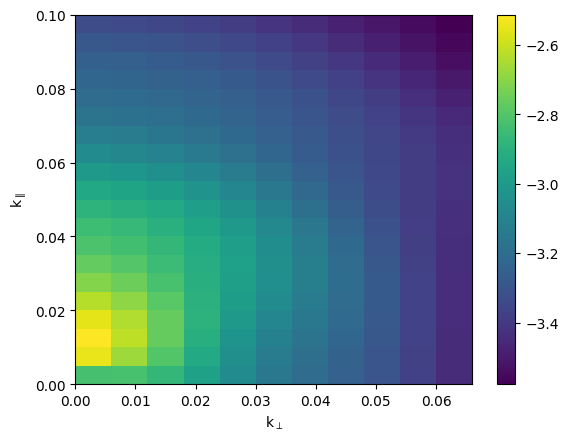

In [30]:
plt.pcolormesh(ps.kperpbins, ps.kparabins, np.log10(pscy).T)
plt.colorbar()
plt.xlabel(r'k$_\perp$')
plt.ylabel(r'k$_\parallel$')

Text(0, 0.5, 'P(k)')

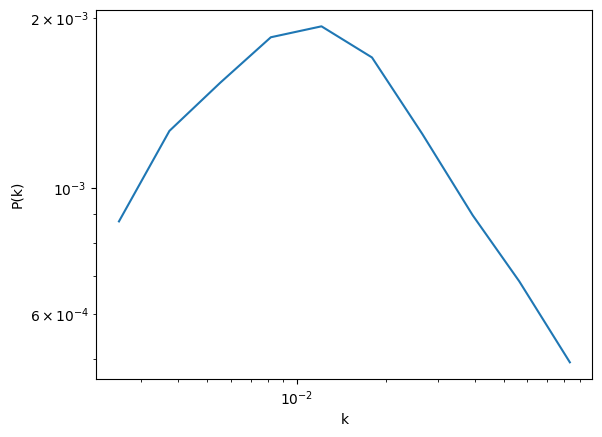

In [31]:
plt.plot(keff, ps1d)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'k')
plt.ylabel(r'P(k)')

## Beam attenuation

The first thing you can add is the beam. This is taken care of by adding a Gaussian attenuation, with the beam width (**sigma, not FWHM**) specified by `ps.sigma_beam_ch`:

In [34]:
ps.sigma_beam_ch = 0.5 # in deg
ps.sigma_beam_in_mpc

np.float64(27.242727548225005)

You can put in a frequency dependent beam as well by passing an array to `ps.sigma_beam_ch`. It matter only in mock simulation. At modelling level the only thing that matters is the `ps.sigma_beam_in_mpc` (which of course is a simplifcation that may be inaccurate). Then you can retrieve the beam attenuation term:

In [ ]:
ps.beam_attenuation().shape


(87, 119, 378)

You can then simply multiply this term **squared** (in auto power spectrum) to your model. If you use the simple model provided in `meer21cm`, then this is automatically applied when you set `sigma_beam_ch` and `include_beam`;

In [41]:
ps.include_beam = [True, False]# first element is HI

In [45]:
ps1d_beam,keff,_ = ps.get_1d_power(ps.auto_power_tracer_1_model)
# this is the same as manually applying average temperature and beam
ps1d_beam2,keff,_ = ps.get_1d_power(
    ps.average_hi_temp**2 * ps.auto_power_tracer_1_model_noobs*ps.beam_attenuation()**2
)


Text(0, 0.5, 'P(k)')

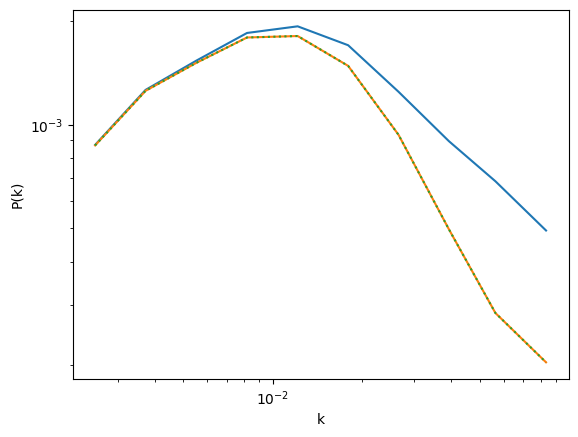

In [47]:
plt.plot(keff, ps1d)
plt.plot(keff, ps1d_beam)
plt.plot(keff, ps1d_beam2,ls=':')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'k')
plt.ylabel(r'P(k)')

## Map resolution

HI intensity maps are averaged into sky pixels and frequency channels. This leads to a window function effect in the power spectrum. In `meer21cm`, you can retrieve this effect by first setting the sampling resolution of the map cube:

In [51]:
ps.sampling_resol = [
    ps.pix_resol_in_mpc,
    ps.pix_resol_in_mpc,
    ps.los_resol_in_mpc,
]

In [53]:
ps.map_sampling().shape

(87, 119, 378)

Again, you can multiply this term **squared** to the power spectrum. In `meer21cm`, this is automatically included if you turn on `ps.include_sky_sampling`:

In [54]:
ps.include_sky_sampling = [True, False]

In [57]:
ps1d_beam_map,keff,_ = ps.get_1d_power(ps.auto_power_tracer_1_model)
# this is the same as manually applying average temperature and beam
ps1d_beam_map2,keff,_ = ps.get_1d_power(
    ps.average_hi_temp**2 
    * ps.auto_power_tracer_1_model_noobs
    * ps.beam_attenuation()**2
    * ps.map_sampling()**2
)


Text(0, 0.5, 'P(k)')

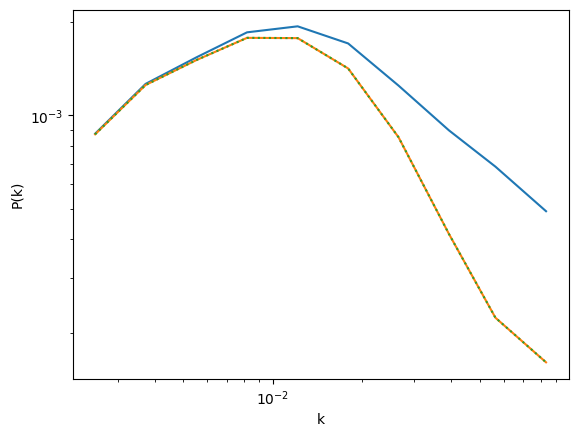

In [59]:
plt.plot(keff, ps1d)
plt.plot(keff, ps1d_beam_map)
plt.plot(keff, ps1d_beam_map2,ls=':')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'k')
plt.ylabel(r'P(k)')

## Gridding compensation

HI intensity maps, as well as galaxy catalogues, are gridded onto the rectangular grid. This creates an additional windowing effect that attenuates the power spectrum. You can add in this effect by having set the box dimensions using `ps.get_enclosing_box()`, specify the mass assignment scheme, and then turn on `ps.compensate`:

In [70]:
ps.compensate = [True, True]
ps.grid_scheme = 'cic' # [nnb, cic, tsc, pcs]

In [71]:
ps.gridding_compensation().shape

(87, 119, 378)

Again, you can multiply this term **squared** to your power spectrum:

In [72]:
ps1d_beam_map_comp,keff,_ = ps.get_1d_power(ps.auto_power_tracer_1_model)
# this is the same as manually applying average temperature and beam
ps1d_beam_map_comp2,keff,_ = ps.get_1d_power(
    ps.average_hi_temp**2 
    * ps.auto_power_tracer_1_model_noobs
    * ps.beam_attenuation()**2
    * ps.map_sampling()**2
    * ps.gridding_compensation()**2
)


Text(0, 0.5, 'P(k)')

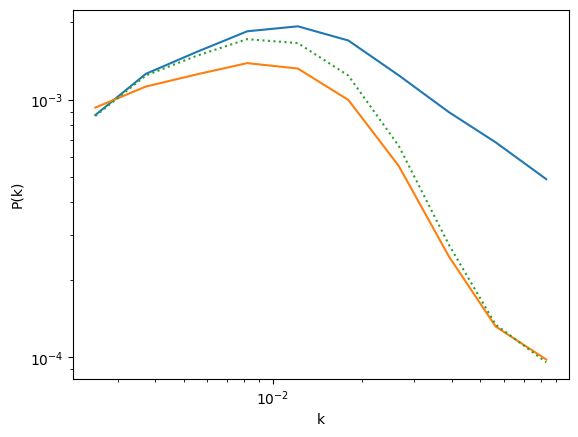

In [73]:
plt.plot(keff, ps1d)
plt.plot(keff, ps1d_beam_map_comp)
plt.plot(keff, ps1d_beam_map_comp2,ls=':')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'k')
plt.ylabel(r'P(k)')

## Weights convolution
Finally, the gridded box is not uniformly weighted when performing Fourier transformation. The weighting effectively creates a convolution in Fourier space with the power spectrum.

In `meer21cm`, you can easily retrieve the box grid sampling by performing a gridding (note this is just to invoke the calculation, you don't need any data in):

In [74]:
ps.grid_data_to_field();

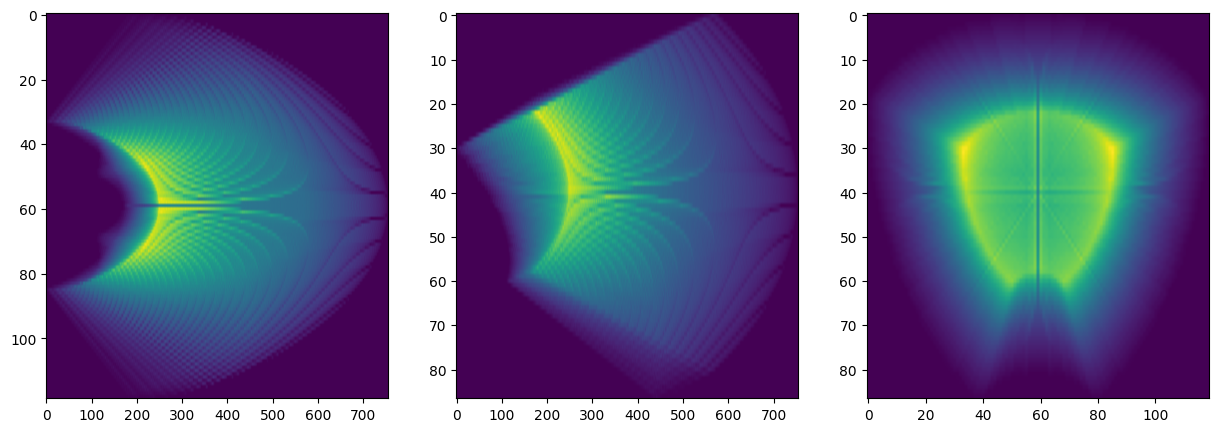

In [75]:
fig, axes = plt.subplots(1,3,figsize=(15,5))
for i, ax in enumerate(axes):
    ax.imshow(ps.counts_in_box.mean(i),aspect='auto')
    

The weighting is then the counts of pixels in the box grids. In `meer21cm` you can set the associated weights to toggle the convolution, which under the hood uses `get_modelpk_conv`:

In [76]:
from meer21cm.power import get_modelpk_conv

In [77]:
ps.weights_1 = ps.counts_in_box.astype('float')

In [78]:
ps1d_beam_map_comp_w,keff,_ = ps.get_1d_power(ps.auto_power_tracer_1_model)
# this is the same as manually applying average temperature and beam
ps1d_beam_map_comp_w2,keff,_ = ps.get_1d_power(
    get_modelpk_conv(ps.average_hi_temp**2 
    * ps.auto_power_tracer_1_model_noobs
    * ps.beam_attenuation()**2
    * ps.map_sampling()**2
    * ps.gridding_compensation()**2,
    ps.weights_1,
    ps.weights_1,
    )
)


Text(0, 0.5, 'P(k)')

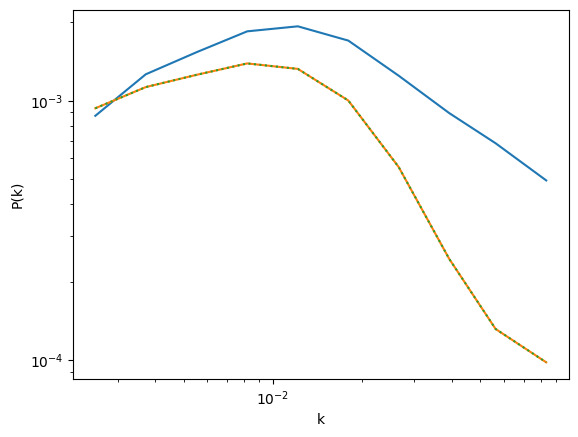

In [79]:
plt.plot(keff, ps1d)
plt.plot(keff, ps1d_beam_map_comp_w)
plt.plot(keff, ps1d_beam_map_comp_w2,ls=':')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'k')
plt.ylabel(r'P(k)')

Note that the weights convolution is normalised in amplitude. To visualise its effect you should check mode-mixing:

In [80]:
ps.weights_1 = None
pscy_noweights,_ = ps.get_cy_power(ps.auto_power_tracer_1_model)
ps.weights_1 = ps.counts_in_box.astype('float')
pscy_weights,_ = ps.get_cy_power(ps.auto_power_tracer_1_model)

In [81]:
np.log10(pscy_noweights).min(),np.log10(pscy_noweights).max(),

(np.float64(-6.6116079471293245), np.float64(-2.52761634643415))

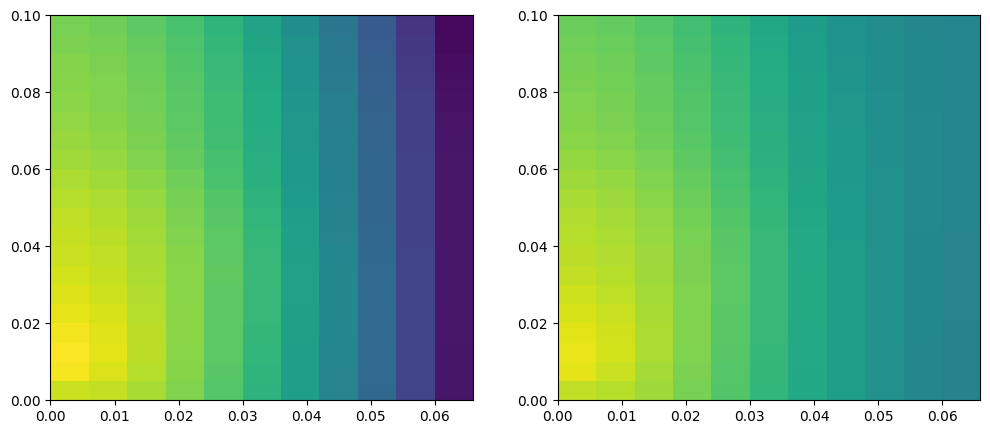

In [82]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
ax = axes[0]
ax.pcolormesh(ps.kperpbins, ps.kparabins, np.log10(pscy_noweights).T, vmin=-6.7,vmax=-2.5)
ax = axes[1]
ax.pcolormesh(ps.kperpbins, ps.kparabins, np.log10(pscy_weights).T, vmin=-6.7,vmax=-2.5)
